In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [6]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [7]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [8]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [9]:
num_beta = 101
min_beta = 1e-10
max_beta = 0.05
num_threshold = 31
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.linspace(start=min_threshold, end=3, steps=num_threshold, dtype=float_type, device=device)
blue_thresh = get_closest_match(values=threshold, target=0.0)
green_thresh = get_closest_match(values=threshold, target=1.0)
red_thresh = get_closest_match(values=threshold, target=2.4)
data_string = f'thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
param_string = f'light_group_{data_string}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta}_steps_1200_lr_0.01_beta_updates_8_param_updates_40000'

In [ ]:
def load_h_only():
    ising_model_file = os.path.join(file_dir, f'ising_model_{param_string}.pt')
    model = torch.load(ising_model_file, weights_only=False)
    print( 'h size', model.h.size() )
    print( 'J size', model.J.size() )
    return model.h.mean(dim=0)
h_mean = load_h_only()

In [11]:
code_start_time = time.time()
atlas_file = os.path.join('D:','glasser','Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii')
atlas_mx = nib.load(atlas_file)
print(f'{time.time() - code_start_time:.3f}, loaded {atlas_file}')
print(atlas_mx)
atlas_data_mx = torch.from_numpy( atlas_mx.get_fdata() ).to(device=device)
print( atlas_data_mx.size() )

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


1.882, loaded D:glasser\Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii
torch.Size([1, 59412])


In [12]:
code_start_time = time.time()
atlas_file = os.path.join('D:','glasser','Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii')
atlas_gl = nib.load(atlas_file)
print(f'{time.time() - code_start_time:.3f}, loaded {atlas_file}')
print(atlas_gl)
atlas_data_gl = torch.from_numpy( atlas_gl.get_fdata() ).to(device=device)
print( atlas_data_gl.size() )

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


2.071, loaded D:glasser\Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii
torch.Size([1, 59412])


In [15]:
print( torch.count_nonzero(atlas_data_mx == atlas_data_gl).item(), 'out of', atlas_data_mx.numel() )

57357 out of 59412


In [19]:
glasser_voxels_file = os.path.join('C:\\Users','agcraig','Documents','GitHub','glasser360','glasser360MNI.nii.gz')
glasser_voxels = nib.load(glasser_voxels_file)
print(glasser_voxels)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (182, 218, 182)
affine:
[[  -1.   -0.    0.   90.]
 [  -0.    1.   -0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 182 218 182   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        

In [20]:
glasser_voxels_data = torch.from_numpy( glasser_voxels.get_fdata() ).to(device=device)
print( glasser_voxels_data.size() )

torch.Size([182, 218, 182])


In [21]:
glasser_voxel_dims = glasser_voxels_data.size()
print( glasser_voxel_dims[0] * glasser_voxel_dims[1] * glasser_voxel_dims[2] )

7221032


In [11]:
selected_threshold = 1.0
threshold_index = torch.argmin( torch.abs(threshold - selected_threshold) )
selected_threshold = threshold[threshold_index]
print(f'selected threshold {selected_threshold:.3g} at index {threshold_index}')
selected_h = h_mean[threshold_index,:]

selected threshold 1 at index 10


In [12]:
def prepend_zero(array:torch.Tensor):
    return torch.cat(   (  torch.zeros( size=(1,), dtype=array.dtype, device=array.device ), array  ), dim=0   )

In [13]:
h_min = selected_h.min()
h_max = selected_h.max()
h_red = (selected_h - h_min)/(h_max - h_min)
h_green = h_red
h_blue = (h_max - selected_h)/(h_max - h_min)
h_red = prepend_zero(h_red)
print( h_red.size() )
h_green = prepend_zero(h_green)
print( h_green.size() )
h_blue = prepend_zero(h_blue)
print( h_blue.size() )

torch.Size([361])
torch.Size([361])
torch.Size([361])


In [31]:
voxel_indices = glasser_voxels_data.int()
h_voxels = torch.stack( (h_red[voxel_indices], h_green[voxel_indices], h_blue[voxel_indices]), dim=-1 )
print( h_voxels.size() )

torch.Size([182, 218, 182, 3])


In [ ]:
h_voxels_bool_np = depytorch( torch.any(h_voxels > 0, dim=-1) )
h_voxels_np = depytorch(h_voxels)
axs = plt.figure().add_subplot(projection='3d')
axs.voxels( h_voxels_bool_np, facecolors=h_voxels_np )
plt.show()

KeyboardInterrupt: 

In [12]:
atlas_indices = atlas_data.int() - 1
mapped_h = selected_h[atlas_indices]
print( mapped_h.size() )

selected threshold 1 at index 10
torch.Size([1, 59412])


In [15]:
new_cifti = nib.cifti2.cifti2.Cifti2Image( dataobj=depytorch(mapped_h), header=atlas.header, nifti_header=atlas.nifti_header, extra=atlas.extra, file_map=atlas.file_map )
new_cifti.update_headers()
mapped_h_file = os.path.join(file_dir, f'mapped_h_{param_string}_selected_thresh_{selected_threshold:.3g}.nii')
nib.save( img=new_cifti, filename=mapped_h_file )
print(f'saved {mapped_h_file}')

saved E:\Ising_model_results_daai\mapped_h_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_selected_thresh_1.nii


In [14]:
ising_model_file = os.path.join(file_dir, f'ising_model_{param_string}.pt')
model = torch.load(ising_model_file, weights_only=False)
print( 'h size', model.h.size() )
print( 'J size', model.J.size() )

h size torch.Size([101, 31, 360])
J size torch.Size([101, 31, 360, 360])


In [15]:
node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False )
print( 'node features size', node_features.size() )
edge_features = torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt'), weights_only=False )
print( 'edge features size', edge_features.size() )

node features size torch.Size([837, 360, 11])
edge features size torch.Size([837, 64620, 13])


In [16]:
mean_state = torch.load( os.path.join(other_file_dir, f'mean_state_all_as_is.pt'), weights_only=False )
print( mean_state.size() )
mean_state_product = torch.load( os.path.join(other_file_dir, f'mean_state_product_all_as_is.pt'), weights_only=False )
print( mean_state_product.size() )

torch.Size([4, 837, 360])
torch.Size([4, 837, 360, 360])


In [17]:
mean_state = torch.load( os.path.join(other_file_dir, f'mean_state_{data_string}.pt'), weights_only=False )
print( mean_state.size() )
mean_state_product = torch.load( os.path.join(other_file_dir, f'mean_state_product_{data_string}.pt'), weights_only=False )
print( mean_state_product.size() )

torch.Size([31, 360])
torch.Size([31, 360, 360])


In [18]:
num_node_features = node_features.size(dim=-1)
num_edge_features = edge_features.size(dim=-1)
num_thresholds = model.h.size(dim=1)
h_mean_repeated = model.h.mean(dim=0).unsqueeze(dim=-1).repeat( (1,1,num_node_features) )
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=model.J.size(dim=-1), device=model.J.device )
J_mean_repeated = model.J[:,:,triu_rows,triu_cols].mean(dim=0).unsqueeze(dim=-1).repeat( (1,1,num_edge_features) )
node_features_mean_repeated = node_features[training_subject_start:training_subject_end,:,:].mean(dim=0).unsqueeze(dim=0).repeat( (num_thresholds,1,1) )
edge_features_mean_repeated = edge_features[training_subject_start:training_subject_end,:,:].mean(dim=0).unsqueeze(dim=0).repeat( (num_thresholds,1,1) )

In [19]:
data_fc = isingmodellight.get_fc(state_mean=mean_state, state_product_mean=mean_state_product, epsilon=0)
print( data_fc.size() )
data_fc_repeated = data_fc[:,triu_rows,triu_cols].unsqueeze(dim=-1).repeat( (1,1,num_edge_features) )

torch.Size([31, 360, 360])


In [20]:
h_node_corr = isingmodellight.get_pairwise_correlation(mat1=h_mean_repeated, mat2=node_features_mean_repeated, epsilon=0, dim=1)
print( h_node_corr.size() )

torch.Size([31, 11])


In [21]:
J_edge_corr = isingmodellight.get_pairwise_correlation(mat1=J_mean_repeated, mat2=edge_features_mean_repeated, epsilon=0, dim=1)
print( J_edge_corr.size() )

torch.Size([31, 13])


In [22]:
fc_edge_corr = isingmodellight.get_pairwise_correlation(mat1=data_fc_repeated, mat2=edge_features_mean_repeated, epsilon=0, dim=1)
print( fc_edge_corr.size() )

torch.Size([31, 13])


In [23]:
brightness = 0.85
thickness_color = [brightness,0.0,0.0]
myelination_color = [0.0,brightness,0.0]
curvature_color = [0.0,0.0,brightness]
sulcus_depth_color = [brightness,0.0,brightness]
j_color = [brightness,brightness,0.0]
fc_color = [0.0,brightness,brightness]

h, thickness correlation is largest at threshold 2.1, correlation -0.362.
h, myelination correlation is largest at threshold 2.1, correlation 0.527.
h, curvature correlation is largest at threshold 2.3, correlation -0.213.
h, sulcus depth correlation is largest at threshold 1.6, correlation -0.287.
J, SC correlation is largest at threshold 0, correlation 0.609.
FC, SC correlation is largest at threshold 3, correlation 0.37.


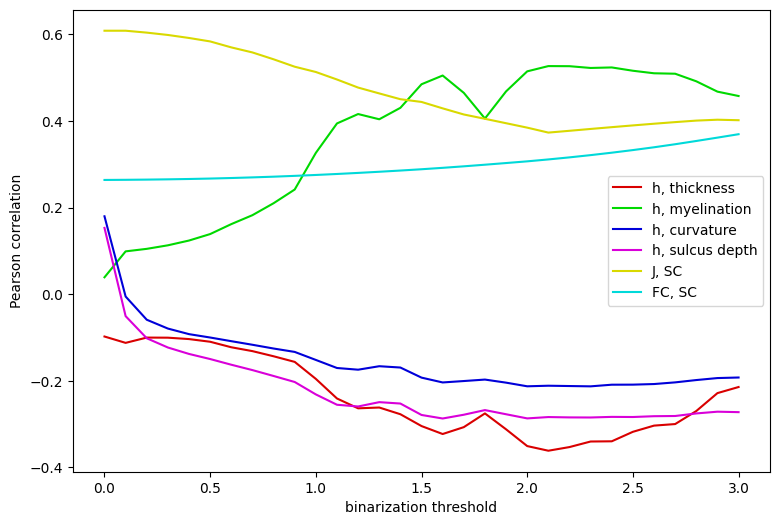

In [24]:
threshold_np = depytorch(threshold)
h_node_corr_np = depytorch(h_node_corr)
J_edge_corr_np = depytorch(J_edge_corr)
fc_edge_corr_np = depytorch(fc_edge_corr)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'h, {feature_name}', color=feature_color)
    biggest_corr_index = torch.argmax( h_node_corr[:,feature_index].abs() )
    print(f'h, {feature_name} correlation is largest at threshold {threshold[biggest_corr_index]:.3g}, correlation {h_node_corr[biggest_corr_index,feature_index]:.3g}.')
axs.plot(threshold_np, J_edge_corr_np[:,0], label='J, SC', color=j_color)
biggest_corr_index = torch.argmax( J_edge_corr[:,0].abs() )
print(f'J, SC correlation is largest at threshold {threshold[biggest_corr_index]:.3g}, correlation {J_edge_corr[biggest_corr_index,0]:.3g}.')
axs.plot(threshold_np, fc_edge_corr_np[:,0], label='FC, SC', color=fc_color)
biggest_corr_index = torch.argmax( fc_edge_corr[:,0].abs() )
print(f'FC, SC correlation is largest at threshold {threshold[biggest_corr_index]:.3g}, correlation {fc_edge_corr[biggest_corr_index,0]:.3g}.')
axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('Pearson correlation')
plt.show()

In [25]:
for threshold_index in [blue_thresh, green_thresh, red_thresh]:
    current_threshold = threshold[threshold_index]
    for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],['red','green','blue','cyan']):
        print(f'h, {feature_name} correlation at threshold {current_threshold:.3g}, correlation {h_node_corr[threshold_index,feature_index]:.3g}.')
    print(f'J, SC correlation at threshold {current_threshold:.3g}, correlation {J_edge_corr[threshold_index,0]:.3g}.')
    print(f'FC, SC correlation at threshold {current_threshold:.3g}, correlation {fc_edge_corr[threshold_index,0]:.3g}.')
    print('')

h, thickness correlation at threshold 0, correlation -0.0978.
h, myelination correlation at threshold 0, correlation 0.039.
h, curvature correlation at threshold 0, correlation 0.18.
h, sulcus depth correlation at threshold 0, correlation 0.153.
J, SC correlation at threshold 0, correlation 0.609.
FC, SC correlation at threshold 0, correlation 0.264.

h, thickness correlation at threshold 1, correlation -0.196.
h, myelination correlation at threshold 1, correlation 0.326.
h, curvature correlation at threshold 1, correlation -0.152.
h, sulcus depth correlation at threshold 1, correlation -0.232.
J, SC correlation at threshold 1, correlation 0.513.
FC, SC correlation at threshold 1, correlation 0.275.

h, thickness correlation at threshold 2.4, correlation -0.34.
h, myelination correlation at threshold 2.4, correlation 0.524.
h, curvature correlation at threshold 2.4, correlation -0.209.
h, sulcus depth correlation at threshold 2.4, correlation -0.284.
J, SC correlation at threshold 2.4,

h thickness torch.return_types.linalg_lstsq(
solution=tensor([[-0.3053],
        [-3.4489]], device='cuda:0'),
residuals=tensor([311.7643], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))
torch.Size([360, 1])
h myelination torch.return_types.linalg_lstsq(
solution=tensor([[0.4448],
        [5.0247]], device='cuda:0'),
residuals=tensor([258.7405], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))
torch.Size([360, 1])
h curvature torch.return_types.linalg_lstsq(
solution=tensor([[-0.2732],
        [-8.9669]], device='cuda:0'),
residuals=tensor([342.6248], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))
torch.Size([360, 1])
h sulcus depth torch.return_types.linalg_lstsq(
solution=tensor([[-0.1081],
        [-1.5362]], device='cuda:0'),
residuals=tensor([329.2088], device='cuda:0'),
rank=ten

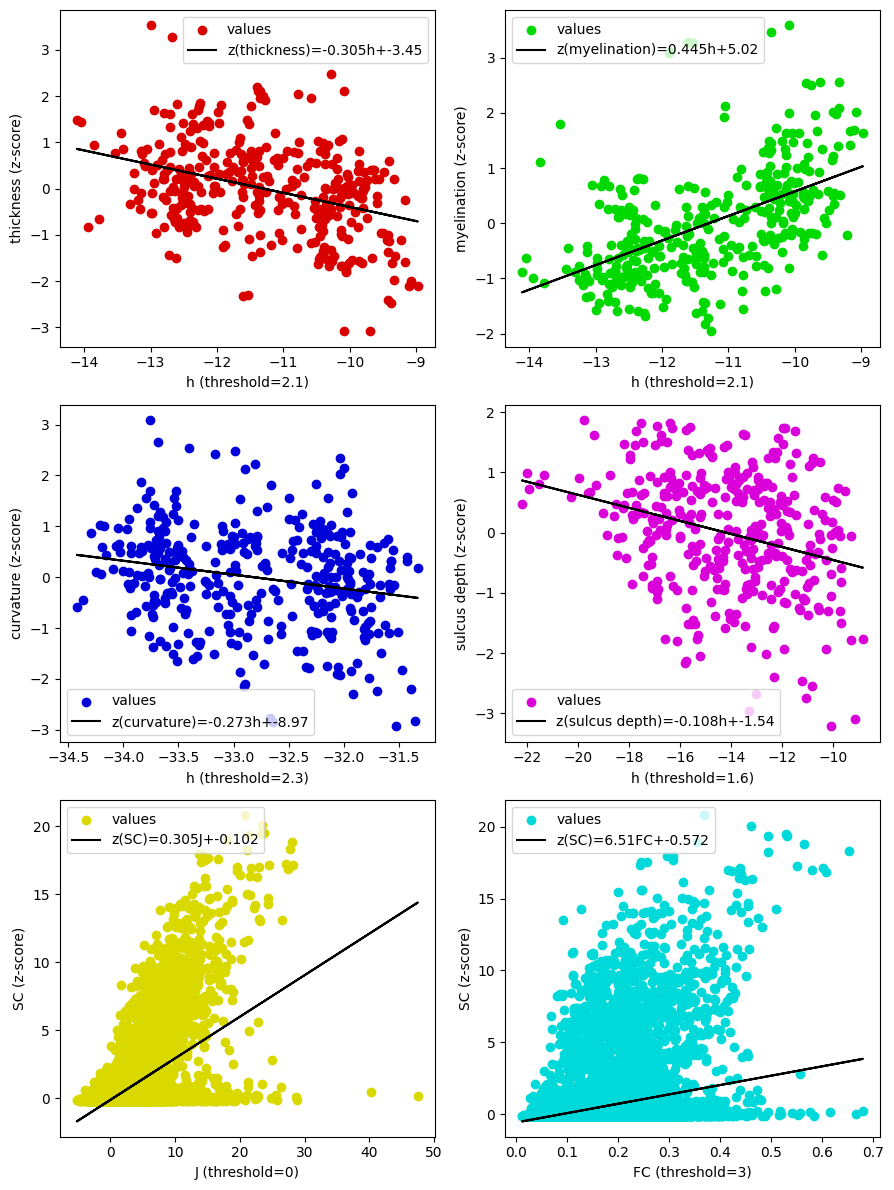

In [26]:
fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(9, 12) )
for feature_index, feature_name, feature_color, feature_row, feature_col in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color],[0,0,1,1],[0,1,0,1]):
    biggest_corr_index = torch.argmax( h_node_corr[:,feature_index].abs() )
    selected_feature = node_features_mean_repeated[biggest_corr_index,:,feature_index]
    feature_std, feature_mean = torch.std_mean(selected_feature)
    feature_z = (selected_feature - feature_mean)/feature_std
    selected_h = h_mean_repeated[biggest_corr_index,:,feature_index]

    h_and_1 = torch.stack(  ( selected_h, torch.ones_like(selected_h) ), dim=-1  )
    feature_z_col = feature_z.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(h_and_1, feature_z_col)
    print('h', feature_name, lst_sq_result)
    feature_z_pred = torch.matmul(h_and_1, lst_sq_result.solution)
    print( feature_z_pred.size() )
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    
    feature_z_np = depytorch(feature_z)
    selected_h_np = depytorch(selected_h)
    feature_z_pred_np = depytorch(feature_z_pred)
    axs[feature_row,feature_col].scatter(selected_h_np, feature_z_np, color=feature_color, label='values')
    axs[feature_row,feature_col].plot(selected_h_np, feature_z_pred_np, color='black', label=f'z({feature_name})={slope:.3g}h+{intercept:.3g}')
    axs[feature_row,feature_col].set_xlabel(f'h (threshold={threshold[biggest_corr_index]:.3g})')
    axs[feature_row,feature_col].set_ylabel(f'{feature_name} (z-score)')
    axs[feature_row,feature_col].legend()

# Now do the same for J-SC
feature_index = 0
feature_name = 'SC'
feature_color = j_color
feature_row = 2
feature_col = 0
biggest_corr_index = torch.argmax( J_edge_corr[:,feature_index].abs() )
selected_feature = edge_features_mean_repeated[biggest_corr_index,:,feature_index]
feature_std, feature_mean = torch.std_mean(selected_feature)
feature_z = (selected_feature - feature_mean)/feature_std
selected_J = J_mean_repeated[biggest_corr_index,:,feature_index]

J_and_1 = torch.stack(  ( selected_J, torch.ones_like(selected_J) ), dim=-1  )
feature_z_col = feature_z.unsqueeze(dim=-1)
lst_sq_result = torch.linalg.lstsq(J_and_1, feature_z_col)
print('J', feature_name, lst_sq_result)
feature_z_pred = torch.matmul(J_and_1, lst_sq_result.solution)
print( feature_z_pred.size() )
slope = lst_sq_result.solution[0].item()
intercept = lst_sq_result.solution[1].item()

feature_z_np = depytorch(feature_z)
selected_J_np = depytorch(selected_J)
feature_z_pred_np = depytorch(feature_z_pred)
axs[feature_row,feature_col].scatter(selected_J_np, feature_z_np, color=feature_color, label='values')
axs[feature_row,feature_col].plot(selected_J_np, feature_z_pred_np, color='black', label=f'z({feature_name})={slope:.3g}J+{intercept:.3g}')
axs[feature_row,feature_col].set_xlabel(f'J (threshold={threshold[biggest_corr_index]:.3g})')
axs[feature_row,feature_col].set_ylabel(f'{feature_name} (z-score)')
axs[feature_row,feature_col].legend()

# Now do the same for FC-SC
feature_index = 0
feature_name = 'SC'
feature_color = fc_color
feature_row = 2
feature_col = 1
biggest_corr_index = torch.argmax( fc_edge_corr[:,feature_index].abs() )
selected_feature = edge_features_mean_repeated[biggest_corr_index,:,feature_index]
feature_std, feature_mean = torch.std_mean(selected_feature)
feature_z = (selected_feature - feature_mean)/feature_std
selected_fc = data_fc_repeated[biggest_corr_index,:,feature_index]

fc_and_1 = torch.stack(  ( selected_fc, torch.ones_like(selected_fc) ), dim=-1  )
feature_z_col = feature_z.unsqueeze(dim=-1)
lst_sq_result = torch.linalg.lstsq(fc_and_1, feature_z_col)
print('FC', feature_name, lst_sq_result)
feature_z_pred = torch.matmul(fc_and_1, lst_sq_result.solution)
print( feature_z_pred.size() )
slope = lst_sq_result.solution[0].item()
intercept = lst_sq_result.solution[1].item()

feature_z_np = depytorch(feature_z)
selected_fc_np = depytorch(selected_fc)
feature_z_pred_np = depytorch(feature_z_pred)
axs[feature_row,feature_col].scatter(selected_fc_np, feature_z_np, color=feature_color, label='values')
axs[feature_row,feature_col].plot(selected_fc_np, feature_z_pred_np, color='black', label=f'z({feature_name})={slope:.3g}FC+{intercept:.3g}')
axs[feature_row,feature_col].set_xlabel(f'FC (threshold={threshold[biggest_corr_index]:.3g})')
axs[feature_row,feature_col].set_ylabel(f'{feature_name} (z-score)')
axs[feature_row,feature_col].legend()

plt.tight_layout()
plt.show()

In [27]:
node_x = node_features_mean_repeated[0,:,5]
node_y = node_features_mean_repeated[0,:,6]
node_z = node_features_mean_repeated[0,:,7]

In [28]:
h_dim = node_x
h_label = 'x (left-to-right)'
v_dim = node_y
v_label = 'y (back-to-front)'
side_by_side_size = (5, 10)

In [29]:
h_dim = node_x
h_label = 'x (left-to-right)'
v_dim = node_z
v_label = 'z (bottom-to-top)'
side_by_side_size = (7.5, 11.25)

In [30]:
h_dim = node_y
h_label = 'y (back-to-front)'
v_dim = node_z
v_label = 'z (bottom-to-top)'
side_by_side_size = (7.5, 11.25)

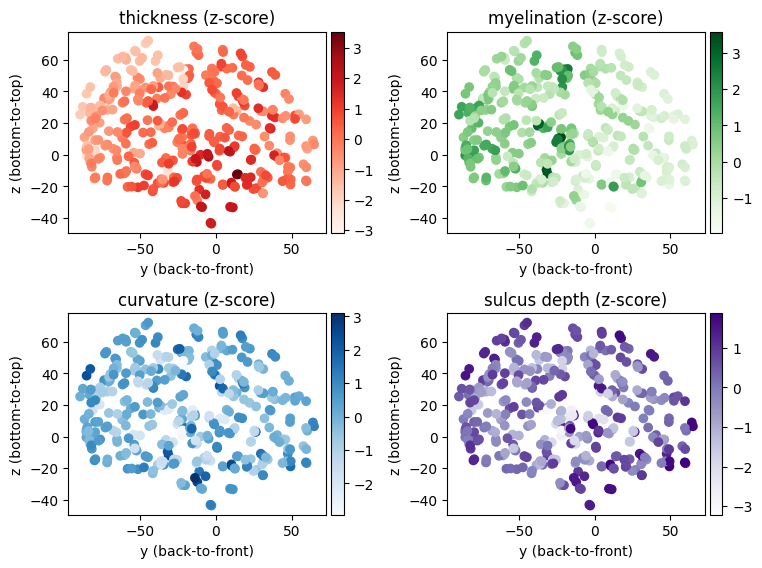

In [31]:
h_dim_np = depytorch(h_dim)
h_range = torch.max(h_dim) - torch.min(h_dim)
v_dim_np = depytorch(v_dim)
v_range = torch.max(v_dim) - torch.min(v_dim)
fig_size_rescale = 0.05
fig, axs = plt.subplots(  nrows=2, ncols=2, figsize=( fig_size_rescale*h_range.item(), fig_size_rescale*v_range.item() )  )
for feature_index, feature_name, feature_color, feature_row, feature_col, feature_cmap in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color],[0,0,1,1],[0,1,0,1],['Reds','Greens','Blues','Purples']):
    divider = make_axes_locatable(axs[feature_row,feature_col])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    selected_feature = node_features_mean_repeated[0,:,feature_index]
    feature_std, feature_mean = torch.std_mean(selected_feature)
    feature_z = (selected_feature - feature_mean)/feature_std
    feature_z_np = depytorch(feature_z)
    plotted_scatter = axs[feature_row,feature_col].scatter(h_dim_np, v_dim_np, c=feature_z_np, cmap=feature_cmap)
    axs[feature_row,feature_col].set_xlabel(h_label)
    axs[feature_row,feature_col].set_ylabel(v_label)
    axs[feature_row,feature_col].set_title(f'{feature_name} (z-score)')
    fig.colorbar(plotted_scatter, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

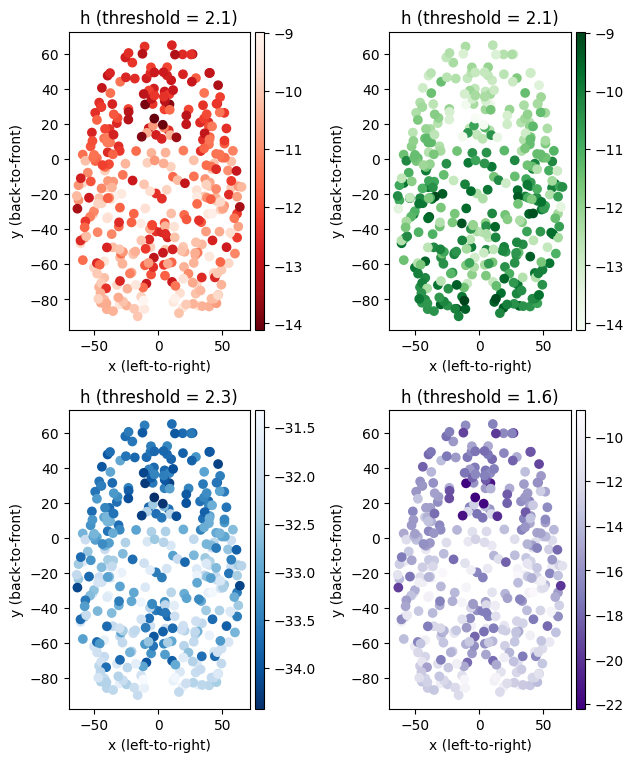

In [74]:
h_dim_np = depytorch(h_dim)
h_range = torch.max(h_dim) - torch.min(h_dim)
v_dim_np = depytorch(v_dim)
v_range = torch.max(v_dim) - torch.min(v_dim)
fig_size_rescale = 0.05
fig, axs = plt.subplots(  nrows=2, ncols=2, figsize=( fig_size_rescale*h_range.item(), fig_size_rescale*v_range.item() )  )
for feature_index, feature_name, feature_color, feature_row, feature_col, feature_cmap in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color],[0,0,1,1],[0,1,0,1],['Reds_r','Greens','Blues_r','Purples_r']):
    divider = make_axes_locatable(axs[feature_row,feature_col])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    biggest_corr_index = torch.argmax( h_node_corr[:,feature_index].abs() )
    selected_h = h_mean_repeated[biggest_corr_index,:,feature_index]
    selected_h_np = depytorch(selected_h)
    plotted_scatter = axs[feature_row,feature_col].scatter(h_dim_np, v_dim_np, c=selected_h_np, cmap=feature_cmap)
    axs[feature_row,feature_col].set_xlabel(h_label)
    axs[feature_row,feature_col].set_ylabel(v_label)
    axs[feature_row,feature_col].set_title(f'h (threshold = {threshold[biggest_corr_index]:.3g})')
    fig.colorbar(plotted_scatter, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

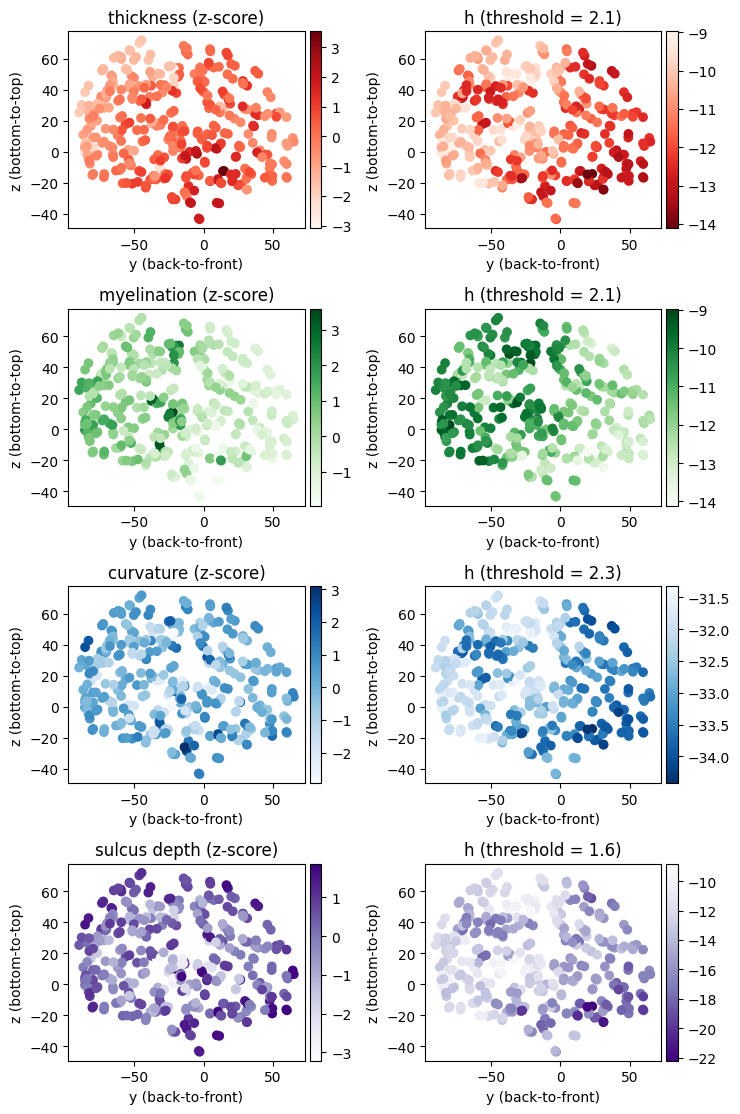

In [96]:
h_dim_np = depytorch(h_dim)
v_dim_np = depytorch(v_dim)
fig_size_rescale = 0.05
fig, axs = plt.subplots( nrows=4, ncols=2, figsize=side_by_side_size )
for feature_index, feature_name, feature_color, feature_cmap, h_cmap in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color],['Reds','Greens','Blues','Purples'],['Reds_r','Greens','Blues_r','Purples_r']):

    current_axs = axs[feature_index,0]
    divider = make_axes_locatable(current_axs)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    selected_feature = node_features_mean_repeated[0,:,feature_index]
    feature_std, feature_mean = torch.std_mean(selected_feature)
    feature_z = (selected_feature - feature_mean)/feature_std
    feature_z_np = depytorch(feature_z)
    plotted_scatter = current_axs.scatter(h_dim_np, v_dim_np, c=feature_z_np, cmap=feature_cmap)
    current_axs.set_xlabel(h_label)
    current_axs.set_ylabel(v_label)
    current_axs.set_title(f'{feature_name} (z-score)')
    fig.colorbar(plotted_scatter, cax=cax, orientation='vertical')
    
    current_axs = axs[feature_index,1]
    divider = make_axes_locatable(current_axs)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    biggest_corr_index = torch.argmax( h_node_corr[:,feature_index].abs() )
    selected_h = h_mean_repeated[biggest_corr_index,:,feature_index]
    selected_h_np = depytorch(selected_h)
    plotted_scatter = current_axs.scatter(h_dim_np, v_dim_np, c=selected_h_np, cmap=h_cmap)
    current_axs.set_xlabel(h_label)
    current_axs.set_ylabel(v_label)
    current_axs.set_title(f'h (threshold = {threshold[biggest_corr_index]:.3g})')
    fig.colorbar(plotted_scatter, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

h thickness torch.return_types.linalg_lstsq(
solution=tensor([[-2.4157e-01],
        [-9.4828e-05]], device='cuda:0'),
residuals=tensor([355.5446], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))
torch.Size([360, 1])
h myelination torch.return_types.linalg_lstsq(
solution=tensor([[9.6263e-02],
        [3.7019e-05]], device='cuda:0'),
residuals=tensor([358.4512], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))
torch.Size([360, 1])
h curvature torch.return_types.linalg_lstsq(
solution=tensor([[4.4425e-01],
        [1.7474e-04]], device='cuda:0'),
residuals=tensor([347.3137], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))
torch.Size([360, 1])
h sulcus depth torch.return_types.linalg_lstsq(
solution=tensor([[3.7814e-01],
        [1.4873e-04]], device='cuda:0'),
residuals=tensor([350.5328]

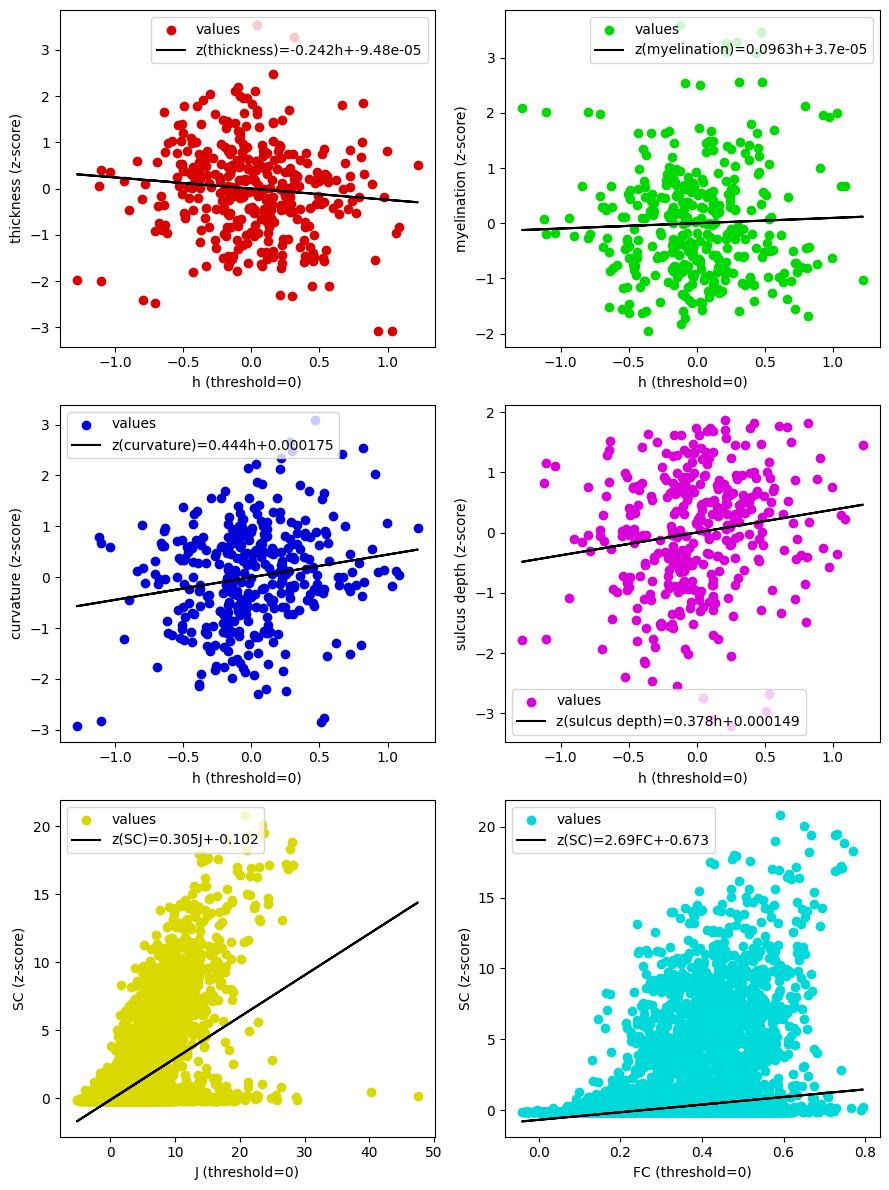

In [32]:
selected_threshold_index = blue_thresh
fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(9, 12) )
for feature_index, feature_name, feature_color, feature_row, feature_col in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color],[0,0,1,1],[0,1,0,1]):
    selected_feature = node_features_mean_repeated[selected_threshold_index,:,feature_index]
    feature_std, feature_mean = torch.std_mean(selected_feature)
    feature_z = (selected_feature - feature_mean)/feature_std
    selected_h = h_mean_repeated[selected_threshold_index,:,feature_index]

    h_and_1 = torch.stack(  ( selected_h, torch.ones_like(selected_h) ), dim=-1  )
    feature_z_col = feature_z.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(h_and_1, feature_z_col)
    print('h', feature_name, lst_sq_result)
    feature_z_pred = torch.matmul(h_and_1, lst_sq_result.solution)
    print( feature_z_pred.size() )
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    
    feature_z_np = depytorch(feature_z)
    selected_h_np = depytorch(selected_h)
    feature_z_pred_np = depytorch(feature_z_pred)
    axs[feature_row,feature_col].scatter(selected_h_np, feature_z_np, color=feature_color, label='values')
    axs[feature_row,feature_col].plot(selected_h_np, feature_z_pred_np, color='black', label=f'z({feature_name})={slope:.3g}h+{intercept:.3g}')
    axs[feature_row,feature_col].set_xlabel(f'h (threshold={threshold[selected_threshold_index]:.3g})')
    axs[feature_row,feature_col].set_ylabel(f'{feature_name} (z-score)')
    axs[feature_row,feature_col].legend()

# Now do the same for J-SC
feature_index = 0
feature_name = 'SC'
feature_color = j_color
feature_row = 2
feature_col = 0
biggest_corr_index = torch.argmax( J_edge_corr[:,feature_index].abs() )
selected_feature = edge_features_mean_repeated[selected_threshold_index,:,feature_index]
feature_std, feature_mean = torch.std_mean(selected_feature)
feature_z = (selected_feature - feature_mean)/feature_std
selected_J = J_mean_repeated[selected_threshold_index,:,feature_index]

J_and_1 = torch.stack(  ( selected_J, torch.ones_like(selected_J) ), dim=-1  )
feature_z_col = feature_z.unsqueeze(dim=-1)
lst_sq_result = torch.linalg.lstsq(J_and_1, feature_z_col)
print('J', feature_name, lst_sq_result)
feature_z_pred = torch.matmul(J_and_1, lst_sq_result.solution)
print( feature_z_pred.size() )
slope = lst_sq_result.solution[0].item()
intercept = lst_sq_result.solution[1].item()

feature_z_np = depytorch(feature_z)
selected_J_np = depytorch(selected_J)
feature_z_pred_np = depytorch(feature_z_pred)
axs[feature_row,feature_col].scatter(selected_J_np, feature_z_np, color=feature_color, label='values')
axs[feature_row,feature_col].plot(selected_J_np, feature_z_pred_np, color='black', label=f'z({feature_name})={slope:.3g}J+{intercept:.3g}')
axs[feature_row,feature_col].set_xlabel(f'J (threshold={threshold[selected_threshold_index]:.3g})')
axs[feature_row,feature_col].set_ylabel(f'{feature_name} (z-score)')
axs[feature_row,feature_col].legend()

# Now do the same for FC-SC
feature_index = 0
feature_name = 'SC'
feature_color = fc_color
feature_row = 2
feature_col = 1
biggest_corr_index = torch.argmax( fc_edge_corr[:,feature_index].abs() )
selected_feature = edge_features_mean_repeated[selected_threshold_index,:,feature_index]
feature_std, feature_mean = torch.std_mean(selected_feature)
feature_z = (selected_feature - feature_mean)/feature_std
selected_fc = data_fc_repeated[selected_threshold_index,:,feature_index]

fc_and_1 = torch.stack(  ( selected_fc, torch.ones_like(selected_fc) ), dim=-1  )
feature_z_col = feature_z.unsqueeze(dim=-1)
lst_sq_result = torch.linalg.lstsq(fc_and_1, feature_z_col)
print('FC', feature_name, lst_sq_result)
feature_z_pred = torch.matmul(fc_and_1, lst_sq_result.solution)
print( feature_z_pred.size() )
slope = lst_sq_result.solution[0].item()
intercept = lst_sq_result.solution[1].item()

feature_z_np = depytorch(feature_z)
selected_fc_np = depytorch(selected_fc)
feature_z_pred_np = depytorch(feature_z_pred)
axs[feature_row,feature_col].scatter(selected_fc_np, feature_z_np, color=feature_color, label='values')
axs[feature_row,feature_col].plot(selected_fc_np, feature_z_pred_np, color='black', label=f'z({feature_name})={slope:.3g}FC+{intercept:.3g}')
axs[feature_row,feature_col].set_xlabel(f'FC (threshold={threshold[selected_threshold_index]:.3g})')
axs[feature_row,feature_col].set_ylabel(f'{feature_name} (z-score)')
axs[feature_row,feature_col].legend()

plt.tight_layout()
plt.show()

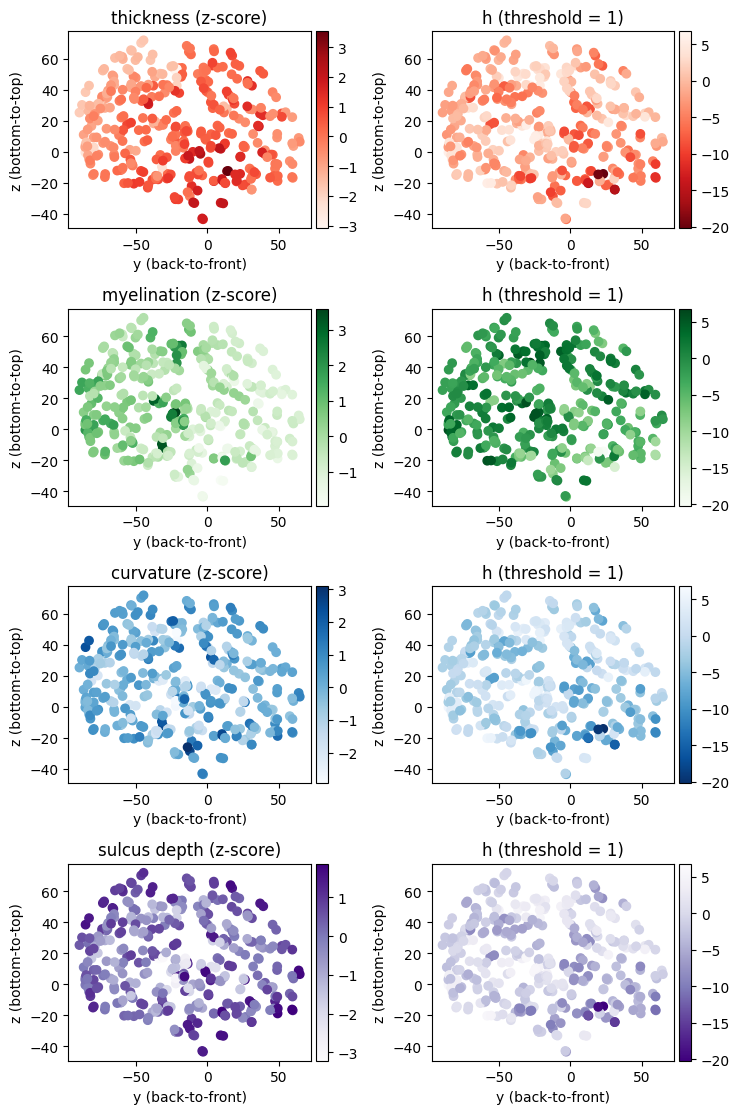

In [100]:
selected_threshold_index = green_thresh
h_dim_np = depytorch(h_dim)
v_dim_np = depytorch(v_dim)
fig_size_rescale = 0.05
fig, axs = plt.subplots( nrows=4, ncols=2, figsize=side_by_side_size )
for feature_index, feature_name, feature_color, feature_cmap, h_cmap in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color],['Reds','Greens','Blues','Purples'],['Reds_r','Greens','Blues_r','Purples_r']):

    current_axs = axs[feature_index,0]
    divider = make_axes_locatable(current_axs)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    selected_feature = node_features_mean_repeated[0,:,feature_index]
    feature_std, feature_mean = torch.std_mean(selected_feature)
    feature_z = (selected_feature - feature_mean)/feature_std
    feature_z_np = depytorch(feature_z)
    plotted_scatter = current_axs.scatter(h_dim_np, v_dim_np, c=feature_z_np, cmap=feature_cmap)
    current_axs.set_xlabel(h_label)
    current_axs.set_ylabel(v_label)
    current_axs.set_title(f'{feature_name} (z-score)')
    fig.colorbar(plotted_scatter, cax=cax, orientation='vertical')
    
    current_axs = axs[feature_index,1]
    divider = make_axes_locatable(current_axs)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    selected_h = h_mean_repeated[selected_threshold_index,:,feature_index]
    selected_h_np = depytorch(selected_h)
    plotted_scatter = current_axs.scatter(h_dim_np, v_dim_np, c=selected_h_np, cmap=h_cmap)
    current_axs.set_xlabel(h_label)
    current_axs.set_ylabel(v_label)
    current_axs.set_title(f'h (threshold = {threshold[selected_threshold_index]:.3g})')
    fig.colorbar(plotted_scatter, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [33]:
start_time = time.time()
num_surrogates = 10000
num_thresholds, num_nodes, num_features = h_mean_repeated.size()
surrogate_h_node_corr = torch.zeros( size=(num_surrogates,num_thresholds,num_features), dtype=h_mean_repeated.dtype, device=h_mean_repeated.device )
for surrogate_index in range(num_surrogates):
    node_order = torch.randperm(n=num_nodes, dtype=int_type, device=h_mean_repeated.device)
    surrogate_h_node_corr[surrogate_index,:,:] = isingmodellight.get_pairwise_correlation(mat1=h_mean_repeated[:,node_order,:], mat2=node_features_mean_repeated, epsilon=0, dim=1)
node_p_values = torch.count_nonzero( surrogate_h_node_corr.abs() >= h_node_corr.abs().unsqueeze(dim=0), dim=0 )/num_surrogates
print( f'time {time.time() - start_time:.3f}', node_p_values.size() )

time 3.375 torch.Size([31, 11])


In [34]:
start_time = time.time()
num_surrogates = 10000
num_thresholds, num_edges, num_features = J_mean_repeated.size()
selected_feature_index = 0
selected_J = J_mean_repeated[:,:,selected_feature_index]
selected_edge_feature = edge_features_mean_repeated[:,:,selected_feature_index]
surrogate_J_edge_corr = torch.zeros( size=(num_surrogates,num_thresholds), dtype=J_mean_repeated.dtype, device=J_mean_repeated.device )
for surrogate_index in range(num_surrogates):
    edge_order = torch.randperm(n=num_edges, dtype=int_type, device=J_mean_repeated.device)
    surrogate_J_edge_corr[surrogate_index,:] = isingmodellight.get_pairwise_correlation(mat1=selected_J[:,edge_order], mat2=selected_edge_feature, epsilon=0, dim=1)
edge_p_values = torch.count_nonzero( surrogate_J_edge_corr.abs() >= J_edge_corr[:,selected_feature_index].abs().unsqueeze(dim=0), dim=0 )/num_surrogates
print( f'time {time.time() - start_time:.3f}', edge_p_values.size() )

time 13.601 torch.Size([31])


In [35]:
start_time = time.time()
num_surrogates = 10000
num_thresholds, num_edges, num_features = data_fc_repeated.size()
selected_feature_index = 0
selected_fc = data_fc_repeated[:,:,selected_feature_index]
selected_edge_feature = edge_features_mean_repeated[:,:,selected_feature_index]
surrogate_fc_edge_corr = torch.zeros( size=(num_surrogates,num_thresholds), dtype=selected_fc.dtype, device=selected_fc.device )
for surrogate_index in range(num_surrogates):
    edge_order = torch.randperm(n=num_edges, dtype=int_type, device=selected_fc.device)
    surrogate_fc_edge_corr[surrogate_index,:] = isingmodellight.get_pairwise_correlation(mat1=selected_fc[:,edge_order], mat2=selected_edge_feature, epsilon=0, dim=1)
fc_sc_p_values = torch.count_nonzero( surrogate_fc_edge_corr.abs() >= fc_edge_corr[:,selected_feature_index].abs().unsqueeze(dim=0), dim=0 )/num_surrogates
print( f'time {time.time() - start_time:.3f}', fc_sc_p_values.size() )

time 13.353 torch.Size([31])


h, thickness p-value is smallest at threshold 1.1, correlation -0.241, p-value 0.
h, myelination p-value is smallest at threshold 0.8, correlation 0.21, p-value 0.
h, curvature p-value is smallest at threshold 2.1, correlation -0.212, p-value 0.
h, sulcus depth p-value is smallest at threshold 0.9, correlation -0.203, p-value 0.
J, SC p-value is smallest at threshold 0, correlation 0.609, p-value 0.
FC, SC p-value is smallest at threshold 0, correlation 0.264, p-value 0.


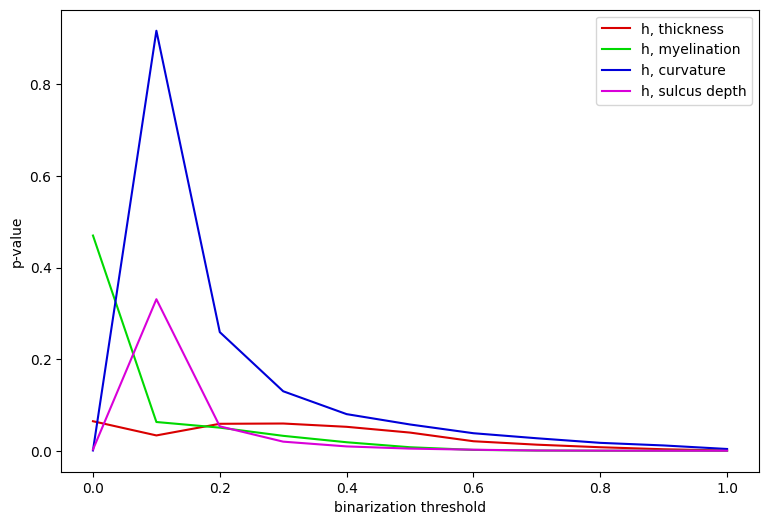

In [36]:
max_threshold_to_plot = green_thresh+1
threshold_np = depytorch(threshold[:max_threshold_to_plot])
node_p_values_np = depytorch(node_p_values)
edge_p_values_np = depytorch(edge_p_values)
fc_sc_p_values_np = depytorch(fc_sc_p_values)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )

for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color, myelination_color, curvature_color, sulcus_depth_color]):
    axs.plot(threshold_np, node_p_values_np[:max_threshold_to_plot,feature_index], label=f'h, {feature_name}', color=feature_color)
    smallest_p_value_index = torch.argmin(node_p_values[:,feature_index])
    print(f'h, {feature_name} p-value is smallest at threshold {threshold[smallest_p_value_index]:.3g}, correlation {h_node_corr[smallest_p_value_index,feature_index]:.3g}, p-value {node_p_values[smallest_p_value_index,feature_index]:.3g}.')

# selected_feature_index = 0

# axs.plot(threshold_np, edge_p_values_np[:max_threshold_to_plot], label='J, SC', color=j_color)
smallest_p_value_index = torch.argmin(edge_p_values)
print(f'J, SC p-value is smallest at threshold {threshold[smallest_p_value_index]:.3g}, correlation {J_edge_corr[smallest_p_value_index,selected_feature_index]:.3g}, p-value {edge_p_values[smallest_p_value_index]:.3g}.')

# axs.plot(threshold_np, fc_sc_p_values_np[:max_threshold_to_plot], label='FC, SC', color=fc_color)
smallest_p_value_index = torch.argmin(fc_sc_p_values)
print(f'FC, SC p-value is smallest at threshold {threshold[smallest_p_value_index]:.3g}, correlation {fc_edge_corr[smallest_p_value_index,selected_feature_index]:.3g}, p-value {fc_sc_p_values[smallest_p_value_index]:.3g}.')

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('p-value')
plt.show()

In [37]:
for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color, myelination_color, curvature_color, sulcus_depth_color]):
    biggest_p_value_index = torch.argmax(node_p_values[:,feature_index])
    print(f'h, {feature_name} p-value is biggest at threshold {threshold[biggest_p_value_index]:.3g}, correlation {h_node_corr[biggest_p_value_index,feature_index]:.3g}, p-value {node_p_values[biggest_p_value_index,feature_index]:.3g}.')

biggest_p_value_index = torch.argmax(edge_p_values)
print(f'J, SC p-value is biggest at threshold {threshold[biggest_p_value_index]:.3g}, correlation {J_edge_corr[biggest_p_value_index,selected_feature_index]:.3g}, p-value {edge_p_values[biggest_p_value_index]:.3g}.')

biggest_p_value_index = torch.argmax(fc_sc_p_values)
print(f'FC, SC p-value is biggest at threshold {threshold[biggest_p_value_index]:.3g}, correlation {fc_edge_corr[biggest_p_value_index,selected_feature_index]:.3g}, p-value {fc_sc_p_values[biggest_p_value_index]:.3g}.')

h, thickness p-value is biggest at threshold 0, correlation -0.0978, p-value 0.0644.
h, myelination p-value is biggest at threshold 0, correlation 0.039, p-value 0.47.
h, curvature p-value is biggest at threshold 0.1, correlation -0.00543, p-value 0.917.
h, sulcus depth p-value is biggest at threshold 0.1, correlation -0.0507, p-value 0.331.
J, SC p-value is biggest at threshold 0, correlation 0.609, p-value 0.
FC, SC p-value is biggest at threshold 0, correlation 0.264, p-value 0.


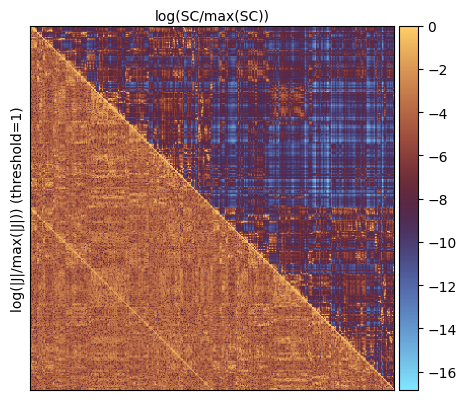

In [39]:
feature_index = 0
feature_name = 'SC'
feature_color = j_color

selected_threshold_index = green_thresh# torch.argmax( J_edge_corr[:,feature_index].abs() )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )

selected_feature = edge_features_mean_repeated[selected_threshold_index,:,feature_index]
feature_std, feature_mean = torch.std_mean(selected_feature)
feature_z = (selected_feature - feature_mean)/feature_std

selected_J = J_mean_repeated[selected_threshold_index,:,feature_index]
J_std, J_mean = torch.std_mean(selected_J)
J_z = (selected_J - J_mean)/J_std

half_mat = torch.zeros( (num_nodes,num_nodes), dtype=selected_J.dtype, device=selected_J.device )
# half_mat[triu_rows,triu_cols] = feature_z# places SC in the upper triangle
# half_mat[triu_cols,triu_rows] = J_z# reverse to place J in the lower triangle
half_mat[triu_rows,triu_cols] = torch.log( selected_feature/torch.max(selected_feature) )# places SC in the upper triangle
abs_J = torch.abs(selected_J)
half_mat[triu_cols,triu_rows] = torch.log( abs_J/torch.max(abs_J) )# reverse to place J in the lower triangle

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
shown_image = axs.imshow( depytorch(half_mat), cmap='managua_r' )
axs.set_xticks([])
axs.set_yticks([])
# axs.set_xlabel(f'{feature_name} (z-score)')# label the top (part of the upper triangle) as SC
axs.set_xlabel(f'log({feature_name}/max({feature_name}))')# label the top (part of the upper triangle) as SC
axs.xaxis.set_label_position('top')
# axs.set_ylabel(f'J (threshold={threshold[selected_threshold_index]:.3g}, z-score)')# label the left (part of the lower triangle) as J
axs.set_ylabel(f'log(|J|/max(|J|)) (threshold={threshold[selected_threshold_index]:.3g})')# label the left (part of the lower triangle) as J
fig.colorbar(shown_image, cax=cax, orientation='vertical')
plt.show()

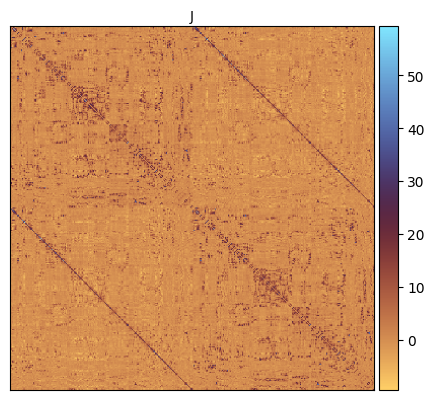

In [42]:
feature_index = 0
feature_name = 'SC'
feature_color = j_color

selected_threshold_index = green_thresh

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )

selected_feature = edge_features_mean_repeated[selected_threshold_index,:,feature_index]
feature_std, feature_mean = torch.std_mean(selected_feature)
feature_z = (selected_feature - feature_mean)/feature_std

selected_J = J_mean_repeated[selected_threshold_index,:,feature_index]

half_mat = torch.zeros( (num_nodes,num_nodes), dtype=selected_J.dtype, device=selected_J.device )
half_mat[triu_rows,triu_cols] = selected_J
half_mat[triu_cols,triu_rows] = selected_J

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
shown_image = axs.imshow( depytorch(half_mat), cmap='managua' )
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel(f'J')
axs.xaxis.set_label_position('top')
fig.colorbar(shown_image, cax=cax, orientation='vertical')
plt.show()

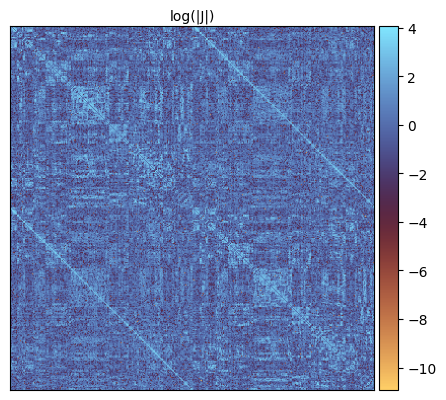

In [43]:
feature_index = 0
feature_name = 'SC'
feature_color = j_color

selected_threshold_index = green_thresh

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )

selected_feature = edge_features_mean_repeated[selected_threshold_index,:,feature_index]
feature_std, feature_mean = torch.std_mean(selected_feature)
feature_z = (selected_feature - feature_mean)/feature_std

selected_J = J_mean_repeated[selected_threshold_index,:,feature_index]
log_abs_J = torch.log( torch.abs(selected_J) )

half_mat = torch.zeros( (num_nodes,num_nodes), dtype=selected_J.dtype, device=selected_J.device )
half_mat[triu_rows,triu_cols] = log_abs_J
half_mat[triu_cols,triu_rows] = log_abs_J

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
shown_image = axs.imshow( depytorch(half_mat), cmap='managua' )
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel(f'log(|J|)')
axs.xaxis.set_label_position('top')
fig.colorbar(shown_image, cax=cax, orientation='vertical')
plt.show()

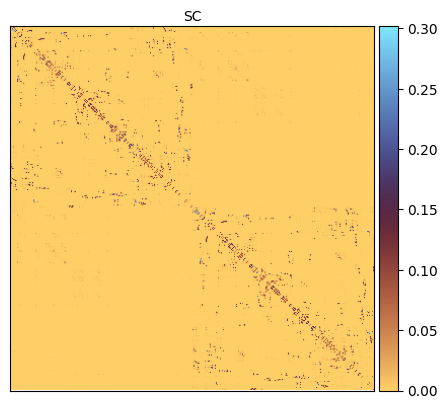

In [45]:
feature_index = 0
feature_name = 'SC'
feature_color = j_color

selected_threshold_index = green_thresh

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )

selected_feature = edge_features_mean_repeated[selected_threshold_index,:,feature_index]

half_mat = torch.zeros( (num_nodes,num_nodes), dtype=selected_J.dtype, device=selected_J.device )
half_mat[triu_rows,triu_cols] = selected_feature
half_mat[triu_cols,triu_rows] = selected_feature

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
shown_image = axs.imshow( depytorch(half_mat), cmap='managua' )
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel(f'{feature_name}')# label the top (part of the upper triangle) as SC
axs.xaxis.set_label_position('top')
fig.colorbar(shown_image, cax=cax, orientation='vertical')
plt.show()

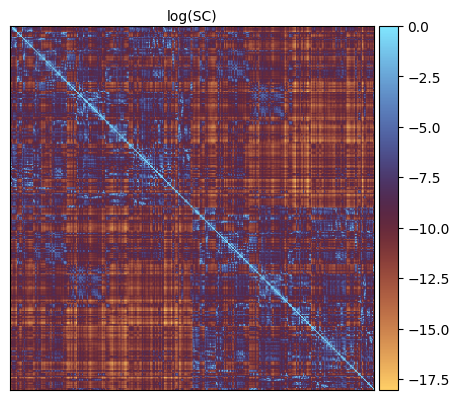

In [46]:
feature_index = 0
feature_name = 'SC'
feature_color = j_color

selected_threshold_index = green_thresh

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )

selected_feature = edge_features_mean_repeated[selected_threshold_index,:,feature_index]
log_feature = torch.log(selected_feature)

half_mat = torch.zeros( (num_nodes,num_nodes), dtype=selected_J.dtype, device=selected_J.device )
half_mat[triu_rows,triu_cols] = log_feature
half_mat[triu_cols,triu_rows] = log_feature

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
shown_image = axs.imshow( depytorch(half_mat), cmap='managua' )
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel(f'log({feature_name})')# label the top (part of the upper triangle) as SC
axs.xaxis.set_label_position('top')
fig.colorbar(shown_image, cax=cax, orientation='vertical')
plt.show()

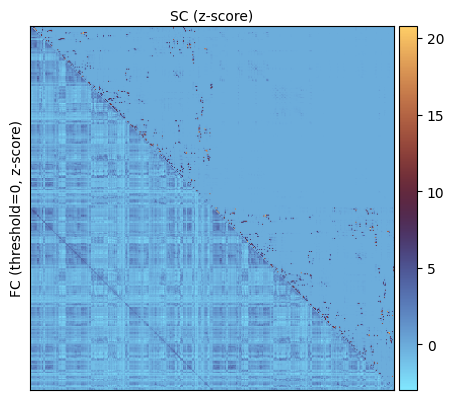

In [47]:
feature_index = 0
feature_name = 'SC'
feature_color = fc_color

selected_threshold_index = blue_thresh# torch.argmax( J_edge_corr[:,feature_index].abs() )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )

selected_feature = edge_features_mean_repeated[selected_threshold_index,:,feature_index]
feature_std, feature_mean = torch.std_mean(selected_feature)
feature_z = (selected_feature - feature_mean)/feature_std

selected_fc = data_fc_repeated[selected_threshold_index,:,feature_index]
fc_std, fc_mean = torch.std_mean(selected_fc)
fc_z = (selected_fc - fc_mean)/fc_std

half_mat = torch.zeros( (num_nodes,num_nodes), dtype=selected_J.dtype, device=selected_J.device )
half_mat[triu_rows,triu_cols] = feature_z# places SC in the upper triangle
half_mat[triu_cols,triu_rows] = fc_z# reverse to place FC in the lower triangle

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
shown_image = axs.imshow( depytorch(half_mat), cmap='managua_r' )
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel(f'{feature_name} (z-score)')# label the top (part of the upper triangle) as SC
axs.xaxis.set_label_position('top')
axs.set_ylabel(f'FC (threshold={threshold[selected_threshold_index]:.3g}, z-score)')# label the left (part of the lower triangle) as FC
fig.colorbar(shown_image, cax=cax, orientation='vertical')
plt.show()

In [48]:
param_string = 'all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000'

In [49]:
def load_mean_params(param_string:str):
    # model_file = os.path.join( other_file_dir, 'ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt' )
    model_file = os.path.join( file_dir, f'ising_model_light_{param_string}.pt' )
    model = torch.load(model_file, weights_only=False)
    return model.h.mean(dim=0), model.J.mean(dim=0)
mean_h, mean_J = load_mean_params(param_string=param_string)
num_nodes = mean_h.size(dim=-1)
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=num_nodes, device=mean_h.device )
mean_J = mean_J[:,triu_rows,triu_cols]
print( 'h size', mean_h.size() )
print( 'J size', mean_J.size() )

h size torch.Size([837, 360])
J size torch.Size([837, 64620])


In [41]:
mean_state = torch.load( os.path.join(other_file_dir, 'mean_state_all_as_is.pt'), weights_only=False )
print( 'mean state size', mean_state.size() )
mean_state_product = torch.load( os.path.join(other_file_dir, 'mean_state_product_all_as_is.pt'), weights_only=False )
print( 'mean state product size', mean_state_product.size() )

mean state size torch.Size([4, 837, 360])
mean state product size torch.Size([4, 837, 360, 360])


In [178]:
mean_state = torch.load( os.path.join(file_dir, 'mean_state_all_mean_std_0.pt'), weights_only=False )
print( 'mean state size', mean_state.size() )
mean_state_product = torch.load( os.path.join(file_dir, 'mean_state_product_all_mean_std_0.pt'), weights_only=False )
print( 'mean state product size', mean_state_product.size() )

mean state size torch.Size([4, 837, 360])
mean state product size torch.Size([4, 837, 360, 360])


In [50]:
mean_state = torch.load( os.path.join(file_dir, 'mean_state_all_mean_std_1.pt'), weights_only=False )
print( 'mean state size', mean_state.size() )
mean_state_product = torch.load( os.path.join(file_dir, 'mean_state_product_all_mean_std_1.pt'), weights_only=False )
print( 'mean state product size', mean_state_product.size() )

mean state size torch.Size([4, 837, 360])
mean state product size torch.Size([4, 837, 360, 360])


In [51]:
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=model.J.size(dim=-1), device=model.J.device )

In [52]:
# Take the means over replicas.
h_mean = model.h.mean(dim=0)
J_mean = model.J[:,:,triu_rows,triu_cols].mean(dim=0)

In [53]:
def get_data_fc_triu():
    mean_state = torch.load( os.path.join(file_dir, 'mean_state_all_mean_std_1.pt'), weights_only=False ).mean(dim=0)
    print( 'mean state size', mean_state.size() )
    mean_state_product = torch.load( os.path.join(file_dir, 'mean_state_product_all_mean_std_1.pt'), weights_only=False ).mean(dim=0)
    print( 'mean state product size', mean_state_product.size() )
    data_fc = isingmodellight.get_fc(state_mean=mean_state, state_product_mean=mean_state_product, epsilon=0)
    print( 'data fc size', data_fc.size() )
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=mean_state.size(dim=-1), device=mean_state.device )
    return data_fc[:,triu_rows,triu_cols]
data_fc_triu = get_data_fc_triu()

mean state size torch.Size([837, 360])
mean state product size torch.Size([837, 360, 360])
data fc size torch.Size([837, 360, 360])


In [42]:
# Take the means over scans.
mean_state_mean = mean_state.mean(dim=0)
mean_state_product_mean = mean_state_product.mean(dim=0)
data_fc = isingmodellight.get_fc(state_mean=mean_state_mean, state_product_mean=mean_state_product_mean, epsilon=0)
print( data_fc.size() )
data_fc_triu = data_fc[:,triu_rows,triu_cols]

torch.Size([837, 360, 360])


In [54]:
num_subjects, num_nodes, num_node_features = node_features.size()
h_node_corr = torch.zeros( size=(num_nodes, num_node_features), dtype=node_features.dtype, device=node_features.device )
for feature_index in range(num_node_features):
    # Take each correlation over subjects so that we have one correlation for each node.
    h_node_corr[:,feature_index] = isingmodellight.get_pairwise_correlation(mat1=h_mean, mat2=node_features[:,:,feature_index], epsilon=0, dim=0)

RuntimeError: The size of tensor a (31) must match the size of tensor b (837) at non-singleton dimension 0

In [ ]:
num_subjects, num_edges, num_edge_features = edge_features.size()
J_edge_corr = torch.zeros( size=(num_edges, num_edge_features), dtype=edge_features.dtype, device=edge_features.device )
for feature_index in range(num_edge_features):
    # Take each correlation over subjects so that we have one correlation for each node pair.
    J_edge_corr[:,feature_index] = isingmodellight.get_pairwise_correlation(mat1=J_mean, mat2=edge_features[:,:,feature_index], epsilon=0, dim=0)

In [43]:
num_subjects, num_edges, num_edge_features = edge_features.size()
fc_edge_corr = torch.zeros( size=(num_edges, num_edge_features), dtype=edge_features.dtype, device=edge_features.device )
for feature_index in range(num_edge_features):
    # Take each correlation over subjects so that we have one correlation for each node pair.
    fc_edge_corr[:,feature_index] = isingmodellight.get_pairwise_correlation(mat1=data_fc_triu, mat2=edge_features[:,:,feature_index], epsilon=0, dim=0)

In [37]:
start_time = time.time()
num_surrogates = 10000
num_subjects, num_nodes, num_features = node_features.size()
h_mean_repeated = h_mean.unsqueeze(dim=-1).repeat( (1,1,num_features) )
surrogate_h_node_corr = torch.zeros( size=(num_surrogates,num_nodes,num_features), dtype=node_features.dtype, device=node_features.device )
for surrogate_index in range(num_surrogates):
    subject_order = torch.randperm(n=num_subjects, dtype=int_type, device=node_features.device)
    surrogate_h_node_corr[surrogate_index,:,:] = isingmodellight.get_pairwise_correlation(mat1=h_mean_repeated[subject_order,:,:], mat2=node_features, epsilon=0, dim=0)
node_p_values = torch.count_nonzero( surrogate_h_node_corr.abs() >= h_node_corr.abs().unsqueeze(dim=0), dim=0 )/num_surrogates
print( f'time {time.time() - start_time:.3f}', node_p_values.size() )

time 5.247 torch.Size([360, 11])


In [11]:
def get_data_sc():
    return torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt'), weights_only=False )[:,:,0].clone()
data_sc = get_data_sc()
print( 'data sc size', data_sc.size() )

data sc size torch.Size([837, 64620])


In [14]:
print( data_sc.device )

cuda:0


In [15]:
J_mean = mean_J
print( J_mean.device )

cuda:0


In [19]:
start_time = time.time()
J_SC_corr = isingmodellight.get_pairwise_correlation(mat1=J_mean, mat2=data_sc, epsilon=0, dim=0)
num_surrogates = 3000
num_subjects, num_edges = data_sc.size()
surrogate_J_SC_corr = torch.zeros( size=(num_surrogates,num_edges), dtype=data_sc.dtype, device=data_sc.device )
subject_order = torch.randperm(n=num_subjects, dtype=int_type, device=data_sc.device)
for surrogate_index in range(num_surrogates):
    torch.randperm(n=num_subjects, dtype=int_type, device=data_sc.device, out=subject_order)
    surrogate_J_SC_corr[surrogate_index,:] = isingmodellight.get_pairwise_correlation(mat1=J_mean[subject_order,:], mat2=data_sc, epsilon=0, dim=0)
SC_J_p_values = torch.count_nonzero( surrogate_J_SC_corr.abs() >= J_SC_corr.abs().unsqueeze(dim=0), dim=0 )/num_surrogates
print( f'time {time.time() - start_time:.3f}', SC_J_p_values.size() )
alpha = 0.001
is_significant = SC_J_p_values.abs() < alpha
sig_J_SC_corrs = J_SC_corr[is_significant]
print(f'{torch.count_nonzero(is_significant)} out of {num_edges} SC-J correlations are significant at the {alpha:.3g} level. These range from {sig_J_SC_corrs.min():.3g} to {sig_J_SC_corrs.max():.3g} with minimum absolute value {sig_J_SC_corrs.abs().min():.3g}')

time 13.145 torch.Size([64620])
1011 out of 64620 SC-J correlations are significant at the 0.001 level. These range from -0.166 to 0.404 with minimum absolute value 0.103


In [22]:
start_time = time.time()
FC_SC_corr = isingmodellight.get_pairwise_correlation(mat1=data_fc_triu, mat2=data_sc, epsilon=0, dim=0)
num_surrogates = 3000
num_subjects, num_edges = data_sc.size()
surrogate_FC_SC_corr = torch.zeros( size=(num_surrogates,num_edges), dtype=data_sc.dtype, device=data_sc.device )
subject_order = torch.randperm(n=num_subjects, dtype=int_type, device=data_sc.device)
for surrogate_index in range(num_surrogates):
    torch.randperm(n=num_subjects, dtype=int_type, device=data_sc.device, out=subject_order)
    surrogate_FC_SC_corr[surrogate_index,:] = isingmodellight.get_pairwise_correlation(mat1=data_fc_triu[subject_order,:], mat2=data_sc, epsilon=0, dim=0)
SC_FC_p_values = torch.count_nonzero( surrogate_FC_SC_corr.abs() >= FC_SC_corr.abs().unsqueeze(dim=0), dim=0 )/num_surrogates
print( f'time {time.time() - start_time:.3f}', SC_FC_p_values.size() )
alpha = 0.001
is_significant = SC_FC_p_values.abs() < alpha
sig_FC_SC_corrs = FC_SC_corr[is_significant]
print(f'{torch.count_nonzero(is_significant)} out of {num_edges} SC-FC correlations are significant at the {alpha:.3g} level. These range from {sig_FC_SC_corrs.min():.3g} to {sig_FC_SC_corrs.max():.3g} with minimum absolute value {sig_FC_SC_corrs.abs().min():.3g}')

time 13.308 torch.Size([64620])
890 out of 64620 SC-FC correlations are significant at the 0.001 level. These range from -0.163 to 0.287 with minimum absolute value 0.101


In [22]:
start_time = time.time()
num_surrogates = 100
num_subjects, num_edges, num_features = edge_features.size()
surrogate_J_edge_corr = torch.zeros( size=(num_surrogates,num_edges,num_features), dtype=edge_features.dtype, device=edge_features.device )
for surrogate_index in range(num_surrogates):
    for feature_index in range(num_edge_features):
        subject_order = torch.randperm(n=num_subjects, dtype=int_type, device=node_features.device)
        surrogate_J_edge_corr[surrogate_index,:,feature_index] = isingmodellight.get_pairwise_correlation(mat1=J_mean[subject_order,:], mat2=edge_features[:,:,feature_index], epsilon=0, dim=0)
edge_J_p_values = torch.count_nonzero( surrogate_J_edge_corr.abs() >= J_edge_corr.abs().unsqueeze(dim=0), dim=0 )/num_surrogates
print( f'time {time.time() - start_time:.3f}', edge_J_p_values.size() )

time 23.227 torch.Size([64620, 13])


In [44]:
start_time = time.time()
num_surrogates = 10000
num_subjects, num_edges, num_features = edge_features.size()
surrogate_FC_SC_corr = torch.zeros( size=(num_surrogates,num_edges), dtype=edge_features.dtype, device=edge_features.device )
data_sc = edge_features[:,:,0]
for surrogate_index in range(num_surrogates):
    subject_order = torch.randperm(n=num_subjects, dtype=int_type, device=node_features.device)
    surrogate_FC_SC_corr[surrogate_index,:] = isingmodellight.get_pairwise_correlation(mat1=data_fc_triu[subject_order,:], mat2=data_sc, epsilon=0, dim=0)
SC_FC_p_values = torch.count_nonzero( surrogate_FC_SC_corr.abs() >= fc_edge_corr[:,0].abs().unsqueeze(dim=0), dim=0 )/num_surrogates
print( f'time {time.time() - start_time:.3f}', SC_FC_p_values.size() )

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.41 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 10.39 GiB is allocated by PyTorch, and 3.64 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

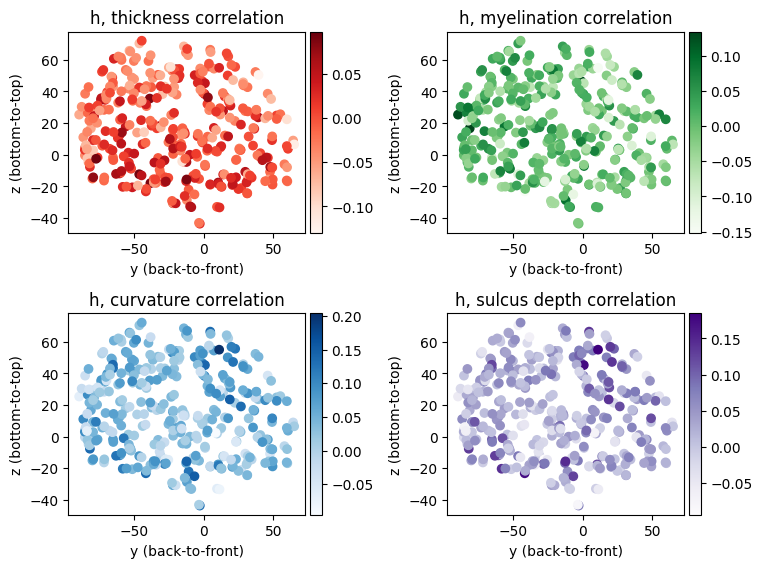

In [188]:
h_dim_np = depytorch(h_dim)
h_range = torch.max(h_dim) - torch.min(h_dim)
v_dim_np = depytorch(v_dim)
v_range = torch.max(v_dim) - torch.min(v_dim)
fig_size_rescale = 0.05
fig, axs = plt.subplots(  nrows=2, ncols=2, figsize=( fig_size_rescale*h_range.item(), fig_size_rescale*v_range.item() )  )
for feature_index, feature_name, feature_color, feature_row, feature_col, feature_cmap in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color],[0,0,1,1],[0,1,0,1],['Reds','Greens','Blues','Purples']):
    divider = make_axes_locatable(axs[feature_row,feature_col])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    selected_feature = node_features_mean_repeated[0,:,feature_index]
    feature_std, feature_mean = torch.std_mean(selected_feature)
    h_node_corr_np = depytorch(h_node_corr[:,feature_index])
    plotted_scatter = axs[feature_row,feature_col].scatter(h_dim_np, v_dim_np, c=h_node_corr_np, cmap=feature_cmap)
    axs[feature_row,feature_col].set_xlabel(h_label)
    axs[feature_row,feature_col].set_ylabel(v_label)
    axs[feature_row,feature_col].set_title(f'h, {feature_name} correlation')
    fig.colorbar(plotted_scatter, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

5


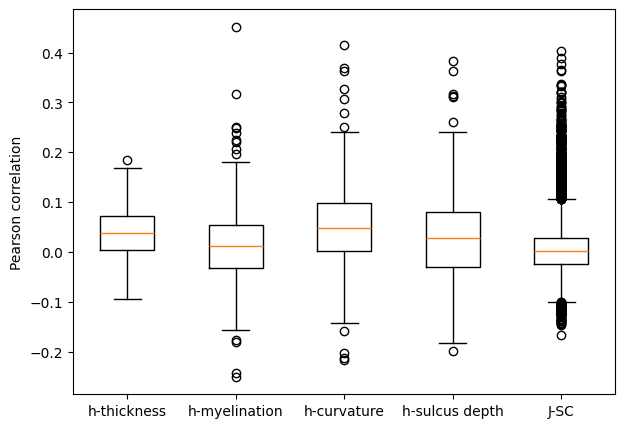

In [35]:
boxplots_list = h_node_corr[:,:num_selected_node_features].transpose(dim0=0, dim1=1).tolist()
boxplots_list.append( J_edge_corr[:,0].tolist() )
print( len(boxplots_list) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(7, 5) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth', 'J-SC']
num_selected_node_features = len(node_feature_labels)
axs.boxplot( boxplots_list, tick_labels=corr_labels )
axs.set_ylabel(f'Pearson correlation')
plt.show()

5


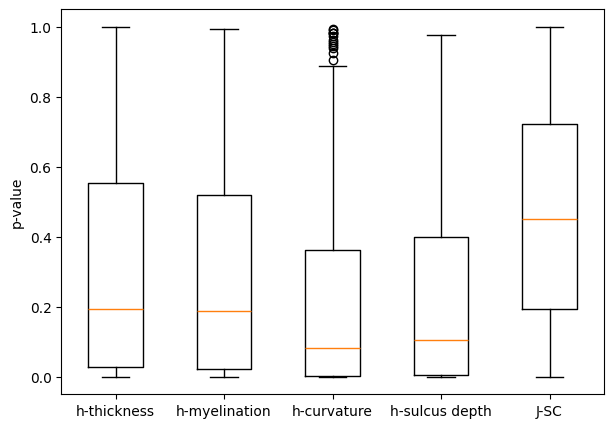

In [38]:
boxplots_list = node_p_values[:,:num_selected_node_features].transpose(dim0=0, dim1=1).tolist()
boxplots_list.append( SC_J_p_values.tolist() )
print( len(boxplots_list) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(7, 5) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth', 'J-SC']
num_selected_node_features = len(node_feature_labels)
axs.boxplot( boxplots_list, tick_labels=corr_labels )
axs.set_ylabel(f'p-value')
plt.show()

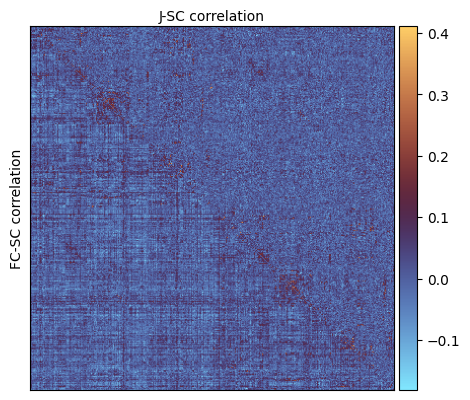

In [190]:
feature_index = 0
feature_name = 'SC'

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )

half_mat = torch.zeros( (num_nodes,num_nodes), dtype=selected_J.dtype, device=selected_J.device )
half_mat[triu_rows,triu_cols] = J_edge_corr[:,feature_index]# places J-SC correlation in the upper triangle
half_mat[triu_cols,triu_rows] = fc_edge_corr[:,feature_index]# reverse to place FC-SC correlation in the lower triangle

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
shown_image = axs.imshow( depytorch(half_mat), cmap='managua_r' )
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel(f'J-{feature_name} correlation')# label the top (part of the upper triangle) as J-SC correlation
axs.xaxis.set_label_position('top')
axs.set_ylabel(f'FC-{feature_name} correlation')# label the left (part of the lower triangle) as FC-SC correlation
fig.colorbar(shown_image, cax=cax, orientation='vertical')
plt.show()

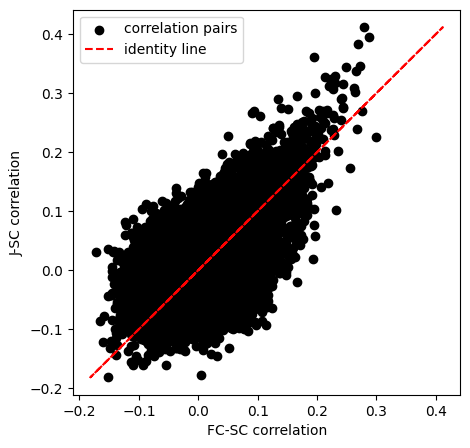

In [191]:
feature_index = 0
feature_name = 'SC'

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )
selected_J_edge_corr_np = depytorch(J_edge_corr[:,feature_index])
axs.scatter( depytorch(fc_edge_corr[:,feature_index]), selected_J_edge_corr_np, color='black', label='correlation pairs' )
axs.plot( selected_J_edge_corr_np, selected_J_edge_corr_np, linestyle='--', color='red', label='identity line' )
axs.set_xlabel(f'FC-{feature_name} correlation')
axs.set_ylabel(f'J-{feature_name} correlation')
axs.legend()
plt.show()


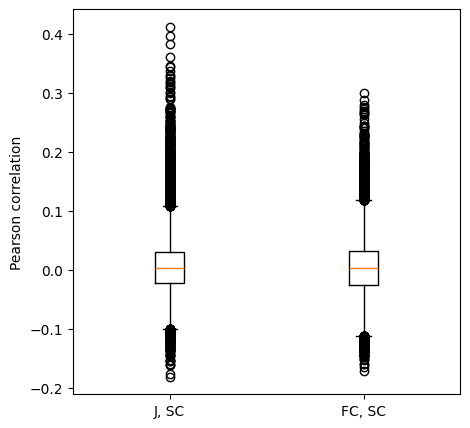

In [192]:
feature_index = 0
feature_name = 'SC'

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )
selected_J_edge_corr_np = depytorch(J_edge_corr[:,feature_index])
box_values = torch.stack( (J_edge_corr[:,feature_index], fc_edge_corr[:,feature_index]), dim=-1 )
axs.boxplot( depytorch(box_values), tick_labels=['J, SC', 'FC, SC'] )
axs.set_ylabel(f'Pearson correlation')
plt.show()


In [193]:
num_J = J_edge_corr[:,feature_index].numel()
num_J_greater = torch.count_nonzero( J_edge_corr[:,feature_index].abs() > fc_edge_corr[:,feature_index].abs() )
fraction_J_greater = num_J_greater/num_J
print(f'{num_J_greater} out of {num_J} node pairs ({fraction_J_greater:.3g}) have a stronger correlation between individual differences in J and SC than between individual differences in FC and SC.')

30685 out of 64620 node pairs (0.475) have a stronger correlation between individual differences in J and SC than between individual differences in FC and SC.


In [194]:
wilcoxon_result = stats.wilcoxon(  depytorch( J_edge_corr[:,feature_index].abs() - fc_edge_corr[:,feature_index].abs() ), alternative='less'  )
print(wilcoxon_result)

WilcoxonResult(statistic=np.float64(963379494.0), pvalue=np.float64(4.7729290545508104e-65))


In [195]:
print( f'range of J-SC correlations [{J_edge_corr[:,feature_index].min():.3g}, {J_edge_corr[:,feature_index].max():.3g}]' )
print( f'range of FC-SC correlations [{fc_edge_corr[:,feature_index].min():.3g}, {fc_edge_corr[:,feature_index].max():.3g}]' )

range of J-SC correlations [-0.181, 0.412]
range of FC-SC correlations [-0.172, 0.299]


In [196]:
print( f'median of absolute value of J-SC correlations {J_edge_corr[:,feature_index].abs().median():.3g}' )
print( f'median of absolute value of FC-SC correlations {fc_edge_corr[:,feature_index].abs().median():.3g}' )

median of absolute value of J-SC correlations 0.026
median of absolute value of FC-SC correlations 0.0286


In [22]:
# Export some things to text files that BrainNet Viewer (https://www.nitrc.org/docman/view.php/504/1190/BrainNet Viewer Manual 1.41.pdf) can use.
names, coords = hcp.load_roi_info(directory_path='D:\\HCP_data', dtype=float_type, device=device)
print( coords.size() )

torch.Size([360, 3])


In [23]:
def write_node_file(file_name:str, coords:torch.Tensor, values_for_color:torch.Tensor=None, values_for_size:torch.Tensor=None, names:list=None):
    num_nodes = coords.size(dim=0)
    if type(values_for_color) == type(None):
        values_for_color = torch.zeros_like(coords[:,0])
    if type(values_for_size) == type(None):
        values_for_size = torch.ones_like(coords[:,0])
    if type(names) == type(None):
        names = ['-']*num_nodes
    node_lines = [ '\t'.join([f'{x:.3g}', f'{y:.3g}', f'{z:.3g}', f'{c:.3g}', f'{s:.3g}', n])+'\n' for x, y, z, c, s, n in zip(coords[:,0], coords[:,1], coords[:,2], values_for_color, values_for_size, names) ]
    with open(file_name, 'w') as node_file:
        node_file.writelines(node_lines)

In [24]:
selected_threshold_index = green_thresh
selected_threshold = threshold[selected_threshold_index]
selected_h = h_mean_repeated[selected_threshold_index,:,0]
node_file_name = os.path.join(file_dir, f'{param_string}_color_by_h_select_thresh_{selected_threshold:.3g}.node')
write_node_file(file_name=node_file_name, coords=coords, values_for_color=selected_h, values_for_size=None, names=names)

In [24]:
mean_node_features = node_features.mean(dim=0)
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
for feature_index in range( len(feature_names) ):
    node_file_name = os.path.join(file_dir, f'mean_{feature_names[feature_index]}.node')
    write_node_file(file_name=node_file_name, coords=coords, values_for_color=mean_node_features[:,feature_index], values_for_size=None, names=names)

In [27]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
for feature_index in range( len(feature_names) ):
    node_file_name = os.path.join(file_dir, f'individual_correlation_{feature_names[feature_index]}_{param_string}.node')
    write_node_file(file_name=node_file_name, coords=coords, values_for_color=h_node_corr[:,feature_index], values_for_size=None, names=names)

In [33]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
for feature_index in range( len(feature_names) ):
    node_file_name = os.path.join(file_dir, f'individual_corr_p_value_{feature_names[feature_index]}_{param_string}.dlm')
    write_node_file(file_name=node_file_name, coords=coords, values_for_color=node_p_values[:,feature_index], values_for_size=None, names=names)

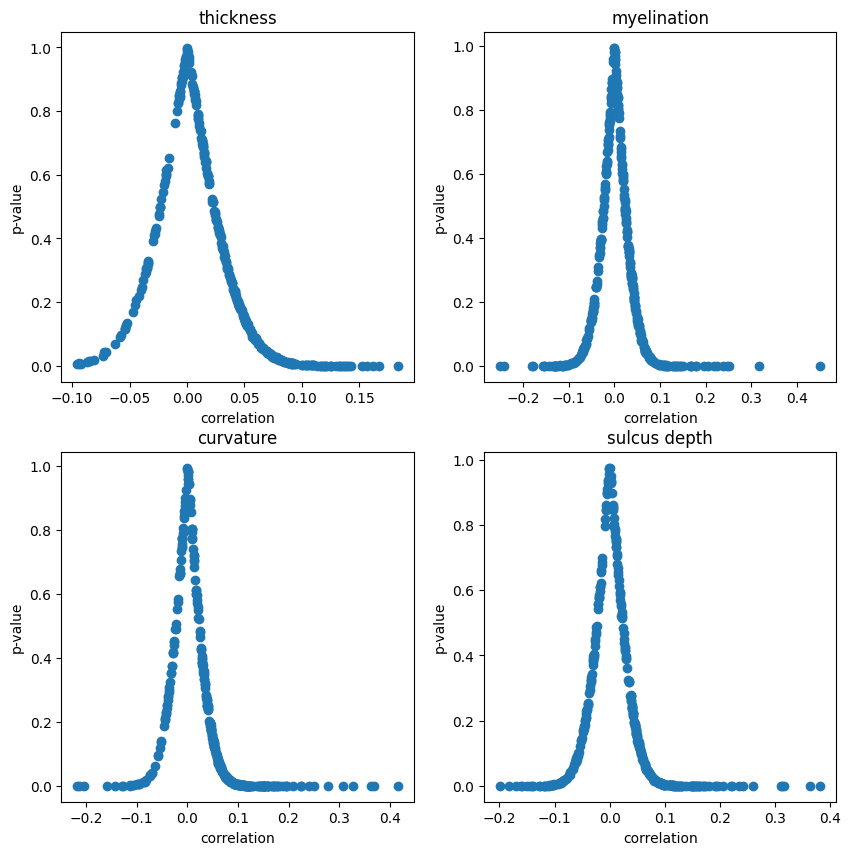

In [39]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
fig, axs = plt.subplots(  nrows=2, ncols=2, figsize=(10, 10)  )
row_index = [0, 0, 1, 1]
col_index = [0, 1, 0, 1]
for feature_index in range( len(feature_names) ):
    ax = axs[ row_index[feature_index], col_index[feature_index] ]
    ax.scatter( depytorch(h_node_corr[:,feature_index]), depytorch(node_p_values[:,feature_index]) )
    ax.set_title(feature_names[feature_index])
    ax.set_xlabel('correlation')
    ax.set_ylabel('p-value')
    # ax.set_xlim([-1.0, 1.0])
    # ax.set_ylim([0.0, 1.0])

In [42]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
alpha = 0.001
for feature_index in range( len(feature_names) ):
    c = h_node_corr[:,feature_index]
    p = node_p_values[:,feature_index]
    is_significant = p < alpha
    num_significant = torch.count_nonzero(is_significant)
    sig_corrs = c[is_significant]
    min_abs_sig_corr = sig_corrs.abs().min()
    print(f'h-{feature_names[feature_index]} correlations: {num_significant} out of {num_nodes} are signficiant at the {alpha:.3g} level. These range from {sig_corrs.min():.3g} to {sig_corrs.max():.3g} with minimum absolute value {min_abs_sig_corr:.3g}.')

h-thickness correlations: 26 out of 360 are signficiant at the 0.001 level. These range from 0.113 to 0.183 with minimum absolute value 0.113.
h-myelination correlations: 52 out of 360 are signficiant at the 0.001 level. These range from -0.251 to 0.452 with minimum absolute value 0.109.
h-curvature correlations: 73 out of 360 are signficiant at the 0.001 level. These range from -0.217 to 0.415 with minimum absolute value 0.113.
h-sulcus depth correlations: 66 out of 360 are signficiant at the 0.001 level. These range from -0.199 to 0.382 with minimum absolute value 0.111.
